# Guys Thesis notebook

## imports and helper function

In [1]:
# math
import numpy as np
import math
import astropy
from astropy.coordinates import SkyCoord
import astropy.units as ua

# oparating system and times and file managing
import os
import time
import pickle
import re

# better resource usage
import multiprocessing
# import mpi4py
# import numba as nb

# simulation file reading and analysis
import h5py 
import gizmo_analysis as gizmo
import halo_analysis as halo
# import utilities as ut
import yt
# from yt.extensions.astro_analysis.halo_analysis import HaloCatalog
import unyt as u
from unyt.physical_constants import mh
import guyProjectionPlot as gpp

# for converting stellar-mass to halo-mass
# from fire_an.mstar_mhalo import loader_smdpl_sfr as ldsmdpl
# from fire_an.makeplots.litcomp import obsdataread as ob


# visuals
from PIL import Image
import ipywidgets as wg
from matplotlib.colors import Normalize
from matplotlib.ticker import AutoLocator, MultipleLocator, MaxNLocator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

#interpolation
from scipy.interpolate import griddata

# galaxy alignment and centering
import edens as ed

## Data loading and preconfoguration of a single simulations

In [2]:
# choosing the simulation to analyze
galaxies_list = ["m11b_res2100","m11d_res7100","m11e_res7100","m11h_res7100","m11i_res7100","m11q_res880",
                 "m12b_res7100","m12c_res7100","m12f_res7100","m12i_res7100","m12m_res7100","m12r_res7100","m12w_res7100","m12z_res4200"
                 ,"m12_elvis_RomeoJuliet_res3500","m12_elvis_ThelmaLouise_res4000","m12_elvis_RomulusRemus_res4000"]
simulation_galaxy = "m12i_res7100"
# simulation_galaxy = "m11d_res7100"
# galaxy = "m11b"
# galaxy = "m11e"
# galaxy = "m11h"
# galaxy = "m11i"
# galaxy = "m11q"
# galaxy = "m12m"
# galaxy = "m12z"
# galaxy = "m12b"
# galaxy = "m12c"
# galaxy = "m12f"
# simulation_galaxy = "m12_elvis_RomeoJuliet_res3500"
# galaxy = "m12_elvis_ThelmaLouise"
# galaxy = "m12r"
# galaxy = "m12w"
# simulation_galaxy = "m12z_res4200"
# simulation_galaxy = "m12_elvis_RomulusRemus_res4000"

# Split the string based on "_res"
parts = simulation_galaxy.split("_res")

# Take the first part (everything before "_res")
galaxy = parts[0]
simulation_directory = "Sims/" + simulation_galaxy + "/output"
# time_BC = 

snapshot_nums = [486,534,600] # simply corresponding to ~11.2Gyrs, ~12.4Gyrs and 13.7Gyrs
snapshot_num = snapshot_nums[2]


# particles types naming
gas = "PartType0"
star = "PartType4"
property = 'H_p0_number_density'

if galaxy == "m11q" or galaxy == "m12_elvis_RomeoJuliet" or galaxy == "m12_elvis_ThelmaLouise" or galaxy =="m12_elvis_RomulusRemus" or galaxy == "m12i" or galaxy == "m12b" or galaxy == "m12c" or galaxy == "m12f" or galaxy == "m12m" or galaxy == "m12r" or galaxy == "m12w" or galaxy == "m12z":
    directory_path = simulation_directory + "/snapdir_" + str(snapshot_num) + "/snapshot_" + str(snapshot_num) + ".0.hdf5"
elif galaxy == "m11b" or galaxy == "m11d" or galaxy == "m11e" or galaxy == "m11h" or galaxy == "m11i":
    directory_path = simulation_directory + "/snapshot_" + str(snapshot_num) + ".hdf5"


# some prefix
output_directory = "output/yt/"
ds = yt.load(directory_path)
ad = ds.all_data()
print(ds.current_time.in_units("Gyr"))

# loading simulation halos using halo_analysis
simulation_directory = "Sims/" + simulation_galaxy
redshift = round(ds.parameters['Redshift'],2)
print(redshift)
hal = halo.io.IO.read_catalogs('redshift', redshift, simulation_directory)
redshift = round(ds.parameters['Redshift'],1)
print(redshift)
# sp = ds.sphere("max", (100, "kpc")) 

yt : [INFO     ] 2024-01-22 10:30:28,023 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-01-22 10:30:28,039 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2024-01-22 10:30:28,041 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2024-01-22 10:30:28,105 Parameters: current_time              = 4.3545571088051405e+17 s
yt : [INFO     ] 2024-01-22 10:30:28,106 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-01-22 10:30:28,108 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-01-22 10:30:28,109 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2024-01-22 10:30:28,111 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-01-22 10:30:28,112 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2024-01-22 10:30:28,113 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2024-01-22 10:30:28,113 Parameters: omega_m

13.79875880550213 Gyr
0.0

# in utilities.simulation.Snapshot():
* reading:  Sims/m12i_res7100/snapshot_times.txt

* input redshift = 0.0:  using snapshot index = 600, redshift = 0.000


# in halo_analysis.halo_io.IO():
* read 35838 halos from:  Sims/m12i_res7100/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5

# in halo_analysis.halo_io.Particle():
* read 35838 halos, 55 have star particles, from:  Sims/m12i_res7100/halo/rockstar_dm/catalog_hdf5/star_600.hdf5
* assigning primary host and coordinates wrt it to halo catalog...  finished

0.0


## Data loading and preconfoguration of multiple simulations

In [2]:
%%time

# choosing the simulation to analyze
galaxies_list = ["m11b_res2100","m11d_res7100","m11e_res7100","m11h_res7100","m11i_res7100","m11q_res880",
                 "m12b_res7100","m12c_res7100","m12f_res7100","m12i_res7100","m12m_res7100","m12r_res7100","m12w_res7100","m12z_res4200"
                 ,"m12_elvis_RomeoJuliet_res3500","m12_elvis_ThelmaLouise_res4000","m12_elvis_RomulusRemus_res4000"]

# galaxies_list = ["m11b_res2100","m11d_res7100","m11e_res7100","m11h_res7100","m11i_res7100","m11q_res880",
#                  "m12b_res7100","m12c_res7100","m12i_res7100","m12r_res7100",
#                  "m12_elvis_RomeoJuliet_res3500"]
# still has no halo: m12m m12_elvis_RomeoJuliet_res3500 m12_elvis_ThelmaLouise_res4000
# galaxies_list = ["m12_elvis_RomeoJuliet_res3500","m12_elvis_ThelmaLouise_res4000","m12_elvis_RomulusRemus_res4000"]


# galaxies_list = ["m11b_res2100","m11d_res7100"]

# some prefix
output_directory = "output/yt/"
snapshot_nums = [486,534,600] # simply corresponding to ~11.2Gyrs, ~12.4Gyrs and 13.7Gyrs
# snapshot_nums = [600]
gas = "PartType0"
star = "PartType4"
directions = ["FaceOn","EdgeOn"]
# direction = ["EdgeOn"]
property = 'H_p0_number_density'
# property = 'velocity'
# property = 'density'
fraction_from_Rvir = 0.6

CPU times: user 9 µs, sys: 7 µs, total: 16 µs
Wall time: 28.4 µs


In [ ]:
%%time

args = [(galaxy,snapshot_nums,output_directory,directions,property) for galaxy in galaxies_list]
print(args)
# print(args)
if __name__ == '__main__':
    num_processes =multiprocessing.cpu_count()
    print("number of processes should be: ",num_processes)
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.starmap(gpp.plot_projection, args)
        # print(results)
        # for result in results:
        #     print(result[0])

[('m11b_res2100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m11d_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m11e_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m11h_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m11i_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m11q_res880', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m12b_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m12c_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m12f_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m12i_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', 'EdgeOn'], 'H_p0_number_density'), ('m12m_res7100', [486, 534, 600], 'output/yt/', ['FaceOn', '

yt : [INFO     ] 2024-01-24 14:00:45,767 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-01-24 14:00:45,767 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-01-24 14:00:45,768 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-01-24 14:00:45,776 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-01-24 14:00:45,777 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-01-24 14:00:45,795 Calculating time from 8.328e-01 to be 3.543e+17 seconds
yt : [INFO     ] 2024-01-24 14:00:45,795 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-01-24 14:00:45,797 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2024-01-24 14:00:45,797 Calculating time from 8.328e-01 to be 3.584e+17 seconds
yt : [INFO     ] 2024-01-24 14:00:45,799 Assuming length units are in kpc/h (

11.2Gyrs for m11i and snapshot: 486
11.2Gyrs for m11d and snapshot: 486
11.2Gyrs for m11e and snapshot: 486
11.2Gyrs for m11h and snapshot: 486


yt : [INFO     ] 2024-01-24 14:00:47,880 Allocating for 6.437e+07 particles
Loading particle index: 100%|██████████| 86/86 [00:00<00:00, 236.65it/s]
yt : [INFO     ] 2024-01-24 14:00:48,669 Allocating for 3.633e+07 particles
yt : [INFO     ] 2024-01-24 14:00:48,742 Allocating for 2.637e+07 particles
Loading particle index: 100%|██████████| 43/43 [00:00<00:00, 661.03it/s]


11.4Gyrs for m11b and snapshot: 486
12.4Gyrs for m11i and snapshot: 534
12.4Gyrs for m11d and snapshot: 534
12.4Gyrs for m11e and snapshot: 534
12.4Gyrs for m11h and snapshot: 534


yt : [INFO     ] 2024-01-24 14:00:50,246 Allocating for 2.637e+07 particles
yt : [INFO     ] 2024-01-24 14:00:50,285 Allocating for 3.633e+07 particles
Loading particle index: 100%|██████████| 61/61 [00:00<00:00, 984.15it/s]
yt : [INFO     ] 2024-01-24 14:00:51,037 Allocating for 6.437e+07 particles
Loading particle index:   0%|          | 0/86 [00:00<?, ?it/s]

13.7Gyrs for m11i and snapshot: 600
Saving snapshot_times for galaxy m11i:
{'486': 11.2, '534': 12.4, '600': 13.7}13.7Gyrs for m11d and snapshot: 600

13.7Gyrs for m11h and snapshot: 600Saving snapshot_times for galaxy m11d:

Saving snapshot_times for galaxy m11h:{'486': 11.2, '534': 12.4, '600': 13.7}

{'486': 11.2, '534': 12.4, '600': 13.7}
13.7Gyrs for m11e and snapshot: 600
Saving snapshot_times for galaxy m11e:
{'486': 11.2, '534': 12.4, '600': 13.7}


Loading particle index:  63%|██████▎   | 54/86 [00:00<00:00, 520.79it/s]

reached H_p0_number_density_projections for m11i


Loading particle index: 100%|██████████| 86/86 [00:00<00:00, 698.21it/s]


reached H_p0_number_density_projections for m11dreached H_p0_number_density_projections for m11h

reached H_p0_number_density_projections for m11e


yt : [INFO     ] 2024-01-24 14:00:51,804 xlim = -49.274812 49.274812
yt : [INFO     ] 2024-01-24 14:00:51,804 xlim = -31.151081 31.151081
yt : [INFO     ] 2024-01-24 14:00:51,804 xlim = -40.233888 40.233888
yt : [INFO     ] 2024-01-24 14:00:51,806 ylim = -31.151081 31.151081
yt : [INFO     ] 2024-01-24 14:00:51,806 ylim = -49.274812 49.274812
yt : [INFO     ] 2024-01-24 14:00:51,806 ylim = -40.233888 40.233888
yt : [INFO     ] 2024-01-24 14:00:51,807 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:00:51,807 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:00:51,808 zlim = -29240.000000 29240.000000


12.5Gyrs for m11b and snapshot: 534


yt : [INFO     ] 2024-01-24 14:00:51,815 xlim = -43.007121 43.007121
yt : [INFO     ] 2024-01-24 14:00:51,816 ylim = -43.007121 43.007121
yt : [INFO     ] 2024-01-24 14:00:51,818 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:00:51,874 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:00:51,874 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:00:51,875 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:00:51,891 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:00:53,674 Allocating for 1.469e+08 particles
yt : [INFO     ] 2024-01-24 14:00:53,772 Allocating for 2.002e+08 particles
yt : [INFO     ] 2024-01-24 14:00:53,847 Allocating for 2.687e+08 particles
yt : [INFO     ] 2024-01-24 14:00:53,889 Allocating for 1.537e+08 p

11.4Gyrs for m12i and snapshot: 486


Loading particle index:   5%|▌         | 13/259 [00:00<00:03, 64.23it/s]

11.4Gyrs for m12f and snapshot: 486


Loading particle index: 100%|██████████| 259/259 [00:00<00:00, 794.95it/s]


11.2Gyrs for m12w and snapshot: 486
11.4Gyrs for m11q and snapshot: 486
13.8Gyrs for m11b and snapshot: 600
Saving snapshot_times for galaxy m11b:
{'486': 11.4, '534': 12.5, '600': 13.8}
reached H_p0_number_density_projections for m11b


yt : [INFO     ] 2024-01-24 14:00:55,692 xlim = -27.034387 27.034387
yt : [INFO     ] 2024-01-24 14:00:55,693 ylim = -27.034387 27.034387
yt : [INFO     ] 2024-01-24 14:00:55,706 zlim = -20000.000000 20000.000000
yt : [INFO     ] 2024-01-24 14:00:55,718 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001


11.3Gyrs for m12z and snapshot: 486
11.2Gyrs for m12r and snapshot: 486


yt : [INFO     ] 2024-01-24 14:00:58,981 Allocating for 3.119e+08 particles
Loading particle index: 100%|██████████| 542/542 [00:00<00:00, 1531.91it/s]
yt : [INFO     ] 2024-01-24 14:01:00,837 Allocating for 2.687e+08 particles
Loading particle index:   0%|          | 0/503 [00:00<?, ?it/s]

11.3Gyrs for m12_elvis_RomulusRemus and snapshot: 486


Loading particle index: 100%|██████████| 503/503 [00:00<00:00, 4569.38it/s]


11.4Gyrs for m12b and snapshot: 486
11.4Gyrs for m12c and snapshot: 486
12.5Gyrs for m11q and snapshot: 534
11.4Gyrs for m12m and snapshot: 486


yt : [INFO     ] 2024-01-24 14:01:01,645 Allocating for 1.538e+08 particles
Loading particle index:   0%|          | 0/272 [00:00<?, ?it/s]yt : [INFO     ] 2024-01-24 14:01:02,072 Allocating for 6.215e+08 particles
yt : [INFO     ] 2024-01-24 14:01:02,092 Allocating for 2.002e+08 particles
Loading particle index: 100%|██████████| 368/368 [00:00<00:00, 1719.21it/s]
yt : [INFO     ] 2024-01-24 14:01:02,426 Allocating for 2.611e+08 particles
Loading particle index:  40%|███▉      | 465/1171 [00:00<00:00, 2619.72it/s]

12.4Gyrs for m12w and snapshot: 534


Loading particle index:  14%|█▎        | 66/485 [00:00<00:00, 491.31it/s]

12.5Gyrs for m12i and snapshot: 534


Loading particle index: 100%|██████████| 485/485 [00:00<00:00, 2194.42it/s]


12.5Gyrs for m12f and snapshot: 534


yt : [INFO     ] 2024-01-24 14:01:03,048 Allocating for 7.712e+08 particles
yt : [INFO     ] 2024-01-24 14:01:03,120 Allocating for 1.471e+08 particles
yt : [INFO     ] 2024-01-24 14:01:03,140 Allocating for 1.269e+08 particles
Loading particle index: 100%|██████████| 272/272 [00:00<00:00, 5389.28it/s]


12.5Gyrs for m12z and snapshot: 534


Loading particle index:   0%|          | 0/233 [00:00<?, ?it/s]969.65it/s]

11.2Gyrs for m12_elvis_RomeoJuliet and snapshot: 486


Loading particle index: 100%|██████████| 233/233 [00:00<00:00, 416.62it/s]


13.8Gyrs for m12i and snapshot: 600
Saving snapshot_times for galaxy m12i:
{'486': 11.4, '534': 12.5, '600': 13.8}
reached H_p0_number_density_projections for m12i


yt : [INFO     ] 2024-01-24 14:01:04,152 xlim = -75.781064 75.781064
yt : [INFO     ] 2024-01-24 14:01:04,154 ylim = -75.781064 75.781064
yt : [INFO     ] 2024-01-24 14:01:04,155 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:01:04,233 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001


12.4Gyrs for m12r and snapshot: 534
11.3Gyrs for m12_elvis_ThelmaLouise and snapshot: 486


yt : [INFO     ] 2024-01-24 14:01:07,590 Allocating for 2.687e+08 particles
Loading particle index: 100%|██████████| 509/509 [00:00<00:00, 2586.57it/s]


13.8Gyrs for m11q and snapshot: 600
Saving snapshot_times for galaxy m11q:
{'486': 11.4, '534': 12.5, '600': 13.8}
reached H_p0_number_density_projections for m11q


yt : [INFO     ] 2024-01-24 14:01:09,171 Allocating for 1.54e+08 particles
yt : [INFO     ] 2024-01-24 14:01:09,231 xlim = -40.942181 40.942181
yt : [INFO     ] 2024-01-24 14:01:09,233 ylim = -40.942181 40.942181
Loading particle index:   0%|          | 0/281 [00:00<?, ?it/s]yt : [INFO     ] 2024-01-24 14:01:09,235 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:01:09,246 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
Loading particle index: 100%|██████████| 281/281 [00:00<00:00, 2373.59it/s]
yt : [INFO     ] 2024-01-24 14:01:09,575 Allocating for 2.002e+08 particles
Loading particle index: 100%|██████████| 484/484 [00:00<00:00, 2883.00it/s]


13.7Gyrs for m12w and snapshot: 600
Saving snapshot_times for galaxy m12w:
{'486': 11.2, '534': 12.4, '600': 13.7}
reached H_p0_number_density_projections for m12w


yt : [INFO     ] 2024-01-24 14:01:10,351 xlim = -72.590817 72.590817
yt : [INFO     ] 2024-01-24 14:01:10,353 ylim = -72.590817 72.590817
yt : [INFO     ] 2024-01-24 14:01:10,354 zlim = -58480.000000 58480.000000
yt : [INFO     ] 2024-01-24 14:01:10,358 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001


13.8Gyrs for m12f and snapshot: 600
Saving snapshot_times for galaxy m12f:
{'486': 11.4, '534': 12.5, '600': 13.8}
13.8Gyrs for m12z and snapshot: 600
Saving snapshot_times for galaxy m12z:
{'486': 11.3, '534': 12.5, '600': 13.8}
reached H_p0_number_density_projections for m12f
reached H_p0_number_density_projections for m12z


yt : [INFO     ] 2024-01-24 14:01:10,993 xlim = -86.304620 86.304620
yt : [INFO     ] 2024-01-24 14:01:10,995 ylim = -86.304620 86.304620
yt : [INFO     ] 2024-01-24 14:01:10,996 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:01:11,000 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:01:11,090 xlim = -67.936212 67.936212
yt : [INFO     ] 2024-01-24 14:01:11,092 ylim = -67.936212 67.936212
yt : [INFO     ] 2024-01-24 14:01:11,093 zlim = -50000.000000 50000.000000
yt : [INFO     ] 2024-01-24 14:01:11,098 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:01:11,105 Allocating for 1.269e+08 particles
Loading particle index: 100%|██████████| 233/233 [00:00<00:00, 785.80it/s]


13.7Gyrs for m12r and snapshot: 600
Saving snapshot_times for galaxy m12r:
{'486': 11.2, '534': 12.4, '600': 13.7}
reached H_p0_number_density_projections for m12r


yt : [INFO     ] 2024-01-24 14:01:12,929 xlim = -69.727208 69.727208
yt : [INFO     ] 2024-01-24 14:01:12,930 ylim = -69.727208 69.727208
yt : [INFO     ] 2024-01-24 14:01:12,931 zlim = -58480.000000 58480.000000
yt : [INFO     ] 2024-01-24 14:01:12,935 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:01:13,041 Allocating for 6.068e+08 particles
Loading particle index: 100%|██████████| 1138/1138 [00:00<00:00, 3332.70it/s]
yt : [INFO     ] 2024-01-24 14:01:13,904 Allocating for 1.566e+08 particles
Loading particle index:  13%|█▎        | 39/289 [00:00<00:01, 212.50it/s]

12.4Gyrs for m12_elvis_RomulusRemus and snapshot: 534


Loading particle index: 100%|██████████| 289/289 [00:00<00:00, 589.02it/s]
yt : [INFO     ] 2024-01-24 14:01:14,516 Allocating for 3.119e+08 particles
yt : [INFO     ] 2024-01-24 14:01:14,654 Allocating for 2.928e+08 particles
Loading particle index:   1%|          | 4/581 [00:00<01:05,  8.87it/s]

12.5Gyrs for m12b and snapshot: 534


Loading particle index:  23%|██▎       | 131/581 [00:01<00:02, 176.73it/s]

12.5Gyrs for m12m and snapshot: 534


Loading particle index: 100%|██████████| 581/581 [00:01<00:00, 366.26it/s]


12.5Gyrs for m12c and snapshot: 534


yt : [INFO     ] 2024-01-24 14:01:18,247 Allocating for 6.215e+08 particles
Loading particle index: 100%|██████████| 1170/1170 [00:00<00:00, 3749.32it/s]


12.4Gyrs for m12_elvis_RomeoJuliet and snapshot: 534


yt : [INFO     ] 2024-01-24 14:01:20,090 Allocating for 7.712e+08 particles
Loading particle index: 100%|██████████| 1454/1454 [00:00<00:00, 4057.32it/s]


12.4Gyrs for m12_elvis_ThelmaLouise and snapshot: 534


yt : [INFO     ] 2024-01-24 14:01:24,065 Allocating for 6.071e+08 particles
Loading particle index: 100%|██████████| 1139/1139 [00:00<00:00, 2700.81it/s]
yt : [INFO     ] 2024-01-24 14:01:25,209 Allocating for 1.567e+08 particles
Loading particle index: 100%|██████████| 289/289 [00:00<00:00, 1028.07it/s]


13.7Gyrs for m12_elvis_RomulusRemus and snapshot: 600
Saving snapshot_times for galaxy m12_elvis_RomulusRemus:
{'486': 11.3, '534': 12.4, '600': 13.7}
reached H_p0_number_density_projections for m12_elvis_RomulusRemus


yt : [INFO     ] 2024-01-24 14:01:25,822 Allocating for 2.93e+08 particles
Loading particle index:   0%|          | 0/541 [00:00<?, ?it/s]yt : [INFO     ] 2024-01-24 14:01:25,911 xlim = -90.637939 90.637939
yt : [INFO     ] 2024-01-24 14:01:25,913 ylim = -90.637939 90.637939
yt : [INFO     ] 2024-01-24 14:01:25,914 zlim = -25000.000000 25000.000000
yt : [INFO     ] 2024-01-24 14:01:25,920 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
Loading particle index:   9%|▊         | 46/541 [00:00<00:03, 149.78it/s]

13.8Gyrs for m12b and snapshot: 600
Saving snapshot_times for galaxy m12b:
{'486': 11.4, '534': 12.5, '600': 13.8}


Loading particle index: 100%|██████████| 541/541 [00:00<00:00, 1078.26it/s]


reached H_p0_number_density_projections for m12b


yt : [INFO     ] 2024-01-24 14:01:26,564 xlim = -82.425687 82.425687
yt : [INFO     ] 2024-01-24 14:01:26,565 ylim = -82.425687 82.425687
yt : [INFO     ] 2024-01-24 14:01:26,567 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:01:26,573 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:01:26,707 Allocating for 3.12e+08 particles
Loading particle index: 100%|██████████| 582/582 [00:00<00:00, 1760.98it/s]


13.8Gyrs for m12m and snapshot: 600
Saving snapshot_times for galaxy m12m:
{'486': 11.4, '534': 12.5, '600': 13.8}
reached H_p0_number_density_projections for m12m


yt : [INFO     ] 2024-01-24 14:01:27,731 xlim = -82.468039 82.468039
yt : [INFO     ] 2024-01-24 14:01:27,747 ylim = -82.468039 82.468039
yt : [INFO     ] 2024-01-24 14:01:27,748 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:01:27,751 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001


13.8Gyrs for m12c and snapshot: 600
Saving snapshot_times for galaxy m12c:
{'486': 11.4, '534': 12.5, '600': 13.8}
reached H_p0_number_density_projections for m12c


yt : [INFO     ] 2024-01-24 14:01:28,290 xlim = -72.559470 72.559470
yt : [INFO     ] 2024-01-24 14:01:28,292 ylim = -72.559470 72.559470
yt : [INFO     ] 2024-01-24 14:01:28,293 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:01:28,313 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:03:25,835 xlim = -40.233888 40.233888
yt : [INFO     ] 2024-01-24 14:03:25,844 ylim = -40.233888 40.233888
yt : [INFO     ] 2024-01-24 14:03:25,849 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:03:25,850 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:03:45,336 xlim = -38.496025 38.496025
yt : [INFO     ] 2024-01-24 14:03:45,339 ylim = -38.496025 38.496025
yt : [INFO     ] 2024-01-24 14:03:45,341 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:03:45,345 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1000 

############################################# finished m11i #############################################       2024-01-24 14:04:43


yt : [INFO     ] 2024-01-24 14:05:14,373 xlim = -47.574435 47.574435
yt : [INFO     ] 2024-01-24 14:05:14,375 ylim = -47.574435 47.574435
yt : [INFO     ] 2024-01-24 14:05:14,376 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:05:14,378 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:05:21,742 xlim = -54.844981 54.844981
yt : [INFO     ] 2024-01-24 14:05:21,752 ylim = -54.844981 54.844981
yt : [INFO     ] 2024-01-24 14:05:21,753 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:05:21,756 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:06:04,156 xlim = -45.022023 45.022023
yt : [INFO     ] 2024-01-24 14:06:04,161 ylim = -45.022023 45.022023
yt : [INFO     ] 2024-01-24 14:06:04,162 zlim = -29240.000000 29240.000000
yt : [INFO     ] 2024-01-24 14:06:04,164 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 

############################################# finished m11e #############################################       2024-01-24 14:09:44


yt : [INFO     ] 2024-01-24 14:10:04,577 xlim = -69.727208 69.727208
yt : [INFO     ] 2024-01-24 14:10:04,580 ylim = -69.727208 69.727208
yt : [INFO     ] 2024-01-24 14:10:04,582 zlim = -58480.000000 58480.000000
yt : [INFO     ] 2024-01-24 14:10:04,584 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:10:21,352 xlim = -75.781064 75.781064
yt : [INFO     ] 2024-01-24 14:10:21,357 ylim = -75.781064 75.781064
yt : [INFO     ] 2024-01-24 14:10:21,359 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:10:21,362 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:10:54,963 xlim = -33.299998 33.299998
yt : [INFO     ] 2024-01-24 14:10:54,965 ylim = -33.299998 33.299998
yt : [INFO     ] 2024-01-24 14:10:54,966 zlim = -20000.000000 20000.000000
yt : [INFO     ] 2024-01-24 14:10:54,968 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 

############################################# finished m11h #############################################       2024-01-24 14:12:29
############################################# finished m11d #############################################       2024-01-24 14:12:33


yt : [INFO     ] 2024-01-24 14:13:01,311 xlim = -86.304620 86.304620
yt : [INFO     ] 2024-01-24 14:13:01,322 ylim = -86.304620 86.304620
yt : [INFO     ] 2024-01-24 14:13:01,333 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:13:01,345 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:13:23,376 xlim = -33.299998 33.299998
yt : [INFO     ] 2024-01-24 14:13:23,380 ylim = -33.299998 33.299998
yt : [INFO     ] 2024-01-24 14:13:23,382 zlim = -20000.000000 20000.000000
yt : [INFO     ] 2024-01-24 14:13:23,384 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:15:05,470 xlim = -82.015492 82.015492
yt : [INFO     ] 2024-01-24 14:15:05,478 ylim = -82.015492 82.015492
yt : [INFO     ] 2024-01-24 14:15:05,485 zlim = -58480.000000 58480.000000
yt : [INFO     ] 2024-01-24 14:15:05,488 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1000 

############################################# finished m11b #############################################       2024-01-24 14:15:09


yt : [INFO     ] 2024-01-24 14:15:31,743 xlim = -84.260114 84.260114
yt : [INFO     ] 2024-01-24 14:15:31,746 ylim = -84.260114 84.260114
yt : [INFO     ] 2024-01-24 14:15:31,748 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:15:31,751 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1000 by 1000
yt : [INFO     ] 2024-01-24 14:16:33,751 xlim = -90.420795 90.420795
yt : [INFO     ] 2024-01-24 14:16:33,755 ylim = -90.420795 90.420795
yt : [INFO     ] 2024-01-24 14:16:33,757 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:16:33,760 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:16:44,583 xlim = -80.513919 80.513919
yt : [INFO     ] 2024-01-24 14:16:44,587 ylim = -80.513919 80.513919
yt : [INFO     ] 2024-01-24 14:16:44,588 zlim = -58480.000000 58480.000000
yt : [INFO     ] 2024-01-24 14:16:44,592 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 

############################################# finished m12r #############################################       2024-01-24 14:35:32


yt : [INFO     ] 2024-01-24 14:36:50,684 xlim = -106.397433 106.397433
yt : [INFO     ] 2024-01-24 14:36:50,688 ylim = -106.397433 106.397433
yt : [INFO     ] 2024-01-24 14:36:50,689 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:36:50,693 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:37:03,495 xlim = -100.529489 100.529489
yt : [INFO     ] 2024-01-24 14:37:03,497 ylim = -100.529489 100.529489
yt : [INFO     ] 2024-01-24 14:37:03,498 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:37:03,499 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:37:14,006 xlim = -90.151318 90.151318
yt : [INFO     ] 2024-01-24 14:37:14,008 ylim = -90.151318 90.151318
yt : [INFO     ] 2024-01-24 14:37:14,010 zlim = -58480.000000 58480.000000
yt : [INFO     ] 2024-01-24 14:37:14,013 Making a fixed resolution buffer of (('gas', 'H_p0_number_density'

############################################# finished m12i #############################################       2024-01-24 14:38:00


yt : [INFO     ] 2024-01-24 14:39:40,934 xlim = -45.314635 45.314635
yt : [INFO     ] 2024-01-24 14:39:40,936 ylim = -45.314635 45.314635
yt : [INFO     ] 2024-01-24 14:39:40,937 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:39:40,939 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1000 by 1000
yt : [INFO     ] 2024-01-24 14:40:28,881 xlim = -77.743204 77.743204
yt : [INFO     ] 2024-01-24 14:40:28,883 ylim = -77.743204 77.743204
yt : [INFO     ] 2024-01-24 14:40:28,885 zlim = -50000.000000 50000.000000
yt : [INFO     ] 2024-01-24 14:40:28,887 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:41:44,172 xlim = -74.246640 74.246640
yt : [INFO     ] 2024-01-24 14:41:44,200 ylim = -74.246640 74.246640
yt : [INFO     ] 2024-01-24 14:41:44,208 zlim = -25000.000000 25000.000000
yt : [INFO     ] 2024-01-24 14:41:44,210 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 

############################################# finished m12b #############################################       2024-01-24 14:42:27
############################################# finished m12w #############################################       2024-01-24 14:42:47


yt : [INFO     ] 2024-01-24 14:43:03,948 xlim = -91.680908 91.680908
yt : [INFO     ] 2024-01-24 14:43:03,957 ylim = -91.680908 91.680908
yt : [INFO     ] 2024-01-24 14:43:03,961 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:43:03,971 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:45:13,624 xlim = -106.397433 106.397433
yt : [INFO     ] 2024-01-24 14:45:13,643 ylim = -106.397433 106.397433
yt : [INFO     ] 2024-01-24 14:45:13,644 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:45:13,645 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:45:27,466 xlim = -87.109085 87.109085
yt : [INFO     ] 2024-01-24 14:45:27,469 ylim = -87.109085 87.109085
yt : [INFO     ] 2024-01-24 14:45:27,470 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:45:27,471 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1

############################################# finished m12f #############################################       2024-01-24 14:52:25


yt : [INFO     ] 2024-01-24 14:54:12,849 xlim = -102.483755 102.483755
yt : [INFO     ] 2024-01-24 14:54:12,851 ylim = -102.483755 102.483755
yt : [INFO     ] 2024-01-24 14:54:12,853 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-24 14:54:12,856 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:55:20,105 xlim = -90.637939 90.637939
yt : [INFO     ] 2024-01-24 14:55:20,120 ylim = -90.637939 90.637939
yt : [INFO     ] 2024-01-24 14:55:20,126 zlim = -25000.000000 25000.000000
yt : [INFO     ] 2024-01-24 14:55:20,127 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 14:56:42,897 xlim = -77.732758 77.732758
yt : [INFO     ] 2024-01-24 14:56:42,899 ylim = -77.732758 77.732758
yt : [INFO     ] 2024-01-24 14:56:42,900 zlim = -46240.000000 46240.000000
yt : [INFO     ] 2024-01-24 14:56:42,902 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1

############################################# finished m11q #############################################       2024-01-24 15:09:12


yt : [INFO     ] 2024-01-24 15:09:37,495 xlim = -78.180753 78.180753
yt : [INFO     ] 2024-01-24 15:09:37,497 ylim = -78.180753 78.180753
yt : [INFO     ] 2024-01-24 15:09:37,498 zlim = -25000.000000 25000.000000
yt : [INFO     ] 2024-01-24 15:09:37,500 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001


############################################# finished m12z #############################################       2024-01-24 15:10:06
############################################# finished m12m #############################################       2024-01-24 15:15:45


yt : [INFO     ] 2024-01-24 15:16:30,688 xlim = -77.209186 77.209186
yt : [INFO     ] 2024-01-24 15:16:30,690 ylim = -77.209186 77.209186
yt : [INFO     ] 2024-01-24 15:16:30,691 zlim = -25000.000000 25000.000000
yt : [INFO     ] 2024-01-24 15:16:30,693 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 15:18:17,856 xlim = -73.127605 73.127605
yt : [INFO     ] 2024-01-24 15:18:17,857 ylim = -73.127605 73.127605
yt : [INFO     ] 2024-01-24 15:18:17,858 zlim = -46240.000000 46240.000000
yt : [INFO     ] 2024-01-24 15:18:17,859 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001


############################################# finished m12c #############################################       2024-01-24 15:19:37


yt : [INFO     ] 2024-01-24 15:35:36,076 xlim = -74.246640 74.246640
yt : [INFO     ] 2024-01-24 15:35:36,077 ylim = -74.246640 74.246640
yt : [INFO     ] 2024-01-24 15:35:36,078 zlim = -25000.000000 25000.000000
yt : [INFO     ] 2024-01-24 15:35:36,079 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 15:36:18,693 xlim = -100.703906 100.703906
yt : [INFO     ] 2024-01-24 15:36:18,695 ylim = -100.703906 100.703906
yt : [INFO     ] 2024-01-24 15:36:18,696 zlim = -25000.000000 25000.000000
yt : [INFO     ] 2024-01-24 15:36:18,698 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1001 by 1001
yt : [INFO     ] 2024-01-24 15:38:43,616 xlim = -85.955292 85.955292
yt : [INFO     ] 2024-01-24 15:38:43,625 ylim = -85.955292 85.955292
yt : [INFO     ] 2024-01-24 15:38:43,626 zlim = -46240.000000 46240.000000
yt : [INFO     ] 2024-01-24 15:38:43,629 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 1

## Halo and simulation properties

In [19]:
h = ds.cosmology.hubble_constant.value
main_halo_index = hal['host.index'][0]
main_halo_center = np.array(hal['position'][main_halo_index]*h) #in kpc
main_halo_virial_radius = hal['radius'][main_halo_index]
fraction_from_Rvir = 0.3
# np.save(output_directory + galaxy + " R.npy",main_halo_virial_radius)
# main_halo_stellar_mass = hal['star.mass'][main_halo_index]
# np.save(output_directory + galaxy + " stellar_mass.npy",main_halo_stellar_mass)

main_halo_virial_radius = hal['radius'][main_halo_index]

main_halo_stellar_mass = hal['star.mass'][main_halo_index]
print(main_halo_center)

[29338.104 30980.111 32479.914]


## Specifing region to focus on (filtering particles via region)

### A box around the main galaxy

In [14]:
ds.domain_right_edge.to('kpc')

unyt_array([85470.08547009, 85470.08547009, 85470.08547009], 'kpc')

In [26]:
# Define the box size (20 kpc)
box_size = 0.2*main_halo_virial_radius  # kpc
left_edge=ds.domain_left_edge
right_edge=ds.domain_right_edge

# Define the box with the center at the densest region and the specified size
region = ds.region(center=main_halo_center,left_edge=left_edge,right_edge=right_edge)

In [ ]:
# Define the box size (20 kpc)
box_size = 0.2*main_halo_virial_radius  # kpc

# Define the box with the center at the densest region and the specified size
region = ds.box(
    main_halo_center - 0.5 * box_size,
    main_halo_center + 0.5 * box_size
)

### A sphere around the main galaxy

In [20]:
radius = 0.2*main_halo_virial_radius
sp = ds.sphere(main_halo_center,(radius,'kpc'))

## Relevant Properties/Calculations of particles

### Calculating the angular momentum of the galaxy using Edens code 

In [ ]:
# r = np.array(region[star,'Coordinates'])
# m = np.array(region[star,'Masses'])
# v = np.array(region[star,'Velocities'])
r = np.array(sp[star,'Coordinates'])
m = np.array(sp[star,'Masses'])
v = np.array(sp[star,'Velocities'])
print(r)
r_centered = r - main_halo_center
print(r_centered)
L, L_size, L_disk = ed.calc_angular_momentum(r_centered,v,m)
print(L_disk)
L_disk_norm = L_disk/np.linalg.norm(L_disk)
print(L_disk_norm)

### Calculating the angular momentum of the galaxy using yt

#### within a box

In [ ]:
search_args = dict(use_gas=False, use_particles=True, particle_type=star) # making sure to use only gas particles (I think) and mass-weighted
L_disk = region.quantities.angular_momentum_vector(**search_args)
L_disk_norm = (L_disk/np.linalg.norm(L_disk)).tolist()
print(L_disk)
print(L_disk_norm)

In [28]:
# sp.quantities.keys()
# sp.set_field_parameter('coordinates',sp['all','Coordinates'])
# print(sp.get_field_parameter('velocity'))
# print(sp.get_field_parameter('coordinates'))
v = region['gas','velocity'].to('km/s')
print(len(v))
print(region.center)
# print(sp['all','Coordinates'].to('km'))
# fn2 = region.save_as_dataset(fields = [('gas','velocity')])
fn = region.save_as_dataset()
box_ds = yt.load(fn)

57060074
[29338.10351562 30980.11132812 32479.9140625 ] code_length


yt : [INFO     ] 2023-11-28 12:27:07,860 Saving field data to yt dataset: snapshot_600_region.h5.
yt : [INFO     ] 2023-11-28 12:27:17,564 Parameters: current_time              = 4.3545571088051405e+17 s
yt : [INFO     ] 2023-11-28 12:27:17,564 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-28 12:27:17,565 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2023-11-28 12:27:17,565 Parameters: domain_right_edge         = [60000. 60000. 60000.] code_length
yt : [INFO     ] 2023-11-28 12:27:17,566 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2023-11-28 12:27:17,566 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2023-11-28 12:27:17,566 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2023-11-28 12:27:17,567 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2023-11-28 12:27:17,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-28 12:27:17,567 Parameters: hubb

In [29]:
# ad2 = box_ds.all_data()
# print(ad2['gas','velocity'])
print(box_ds.all_data())

p = yt.ProjectionPlot(box_ds,'z',center = main_halo_center,fields = ('gas','velocity'))
p.show()
print("lol")

ValueError: max() arg is an empty sequence

#### within a sphere

In [21]:
%%time

search_args = dict(use_gas=False, use_particles=True, particle_type=star) # making sure to use only star particles (I think) and mass-weighted
L_disk = sp.quantities.angular_momentum_vector(**search_args)
L_disk_norm = (L_disk/np.linalg.norm(L_disk)).tolist()
print(L_disk)
print(L_disk_norm)

[-8.11785901e+28 -3.03260585e+28 -1.42656097e+29] cm**2/s
[-0.4863488214230095, -0.18168636310493685, -0.854666536938326]
CPU times: user 20.4 s, sys: 692 ms, total: 21.1 s
Wall time: 21.2 s


### extracting other usful properties of particles with the region

In [ ]:
gas_density = np.array(region[gas,'Density'])
gas_temperature = np.array(region[gas,'Temperature'])

## Face-on OR Edge-on integration for single use 

### FaceOn

yt : [INFO     ] 2024-01-04 15:45:29,615 xlim = -94.252991 94.252991
yt : [INFO     ] 2024-01-04 15:45:29,617 ylim = -94.252991 94.252991
yt : [INFO     ] 2024-01-04 15:45:29,618 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2024-01-04 15:45:29,621 Making a fixed resolution buffer of (('gas', 'density')) 1001 by 1001


Saving to: output/yt/m12i/Gyrs13.8_ssn600.npy
for galaxy: m12i its center is: [29338.104 30980.111 32479.914]



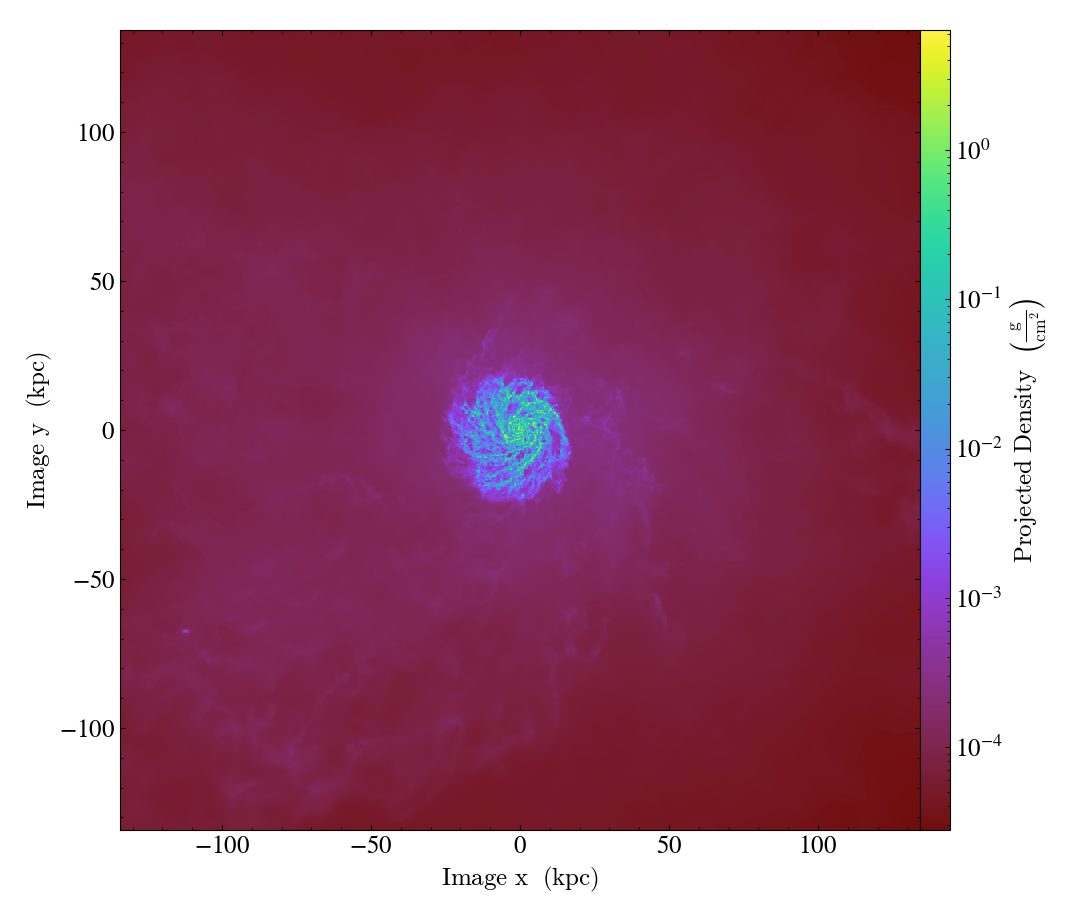

CPU times: user 34min 13s, sys: 2min 46s, total: 36min 59s
Wall time: 4min 34s


In [23]:
%%time

z_hat = L_disk_norm

# saving for later plots
snapshot_time = round(float(ds.current_time.in_units("Gyr")), 1)  
file_path = output_directory + galaxy + "/Gyrs" + str(snapshot_time) + "_ssn" + str(snapshot_num) + ".npy"
# print("Saving to:", file_path)
# np.save(file_path, np.array(snapshot_time))

# loading fields from memory
# main_halo_virial_radius = np.load(output_directory + galaxy + "/R Z" + str(redshift) + "_ssn" +str(snapshot_num) + ".npy")
# main_halo_center = np.load(output_directory + galaxy + "/halo_center Z" + str(redshift) + "_ssn" +str(snapshot_num) + ".npy")

# settings for ProjectionPlot
width = 2*fraction_from_Rvir*main_halo_virial_radius
cell_size = width/1000
num_cells = int(width/cell_size)
adj_width = cell_size*num_cells
property = "H_p0_number_density"
property = 'density'
fields=('gas', property)
center = main_halo_center
print("for galaxy: " + galaxy + " its center is: " + str(center))
directions = ["FaceOn","EdgeOn"]
directions = ["FaceOn"]
# directions = ["EdgeOn"]
for direction in directions:
    if direction == "EdgeOn":
        arbitrary_vector = [1,1,3]
        y_hat = np.cross(z_hat,arbitrary_vector) # projection on Edge
        p = yt.ProjectionPlot(ds, y_hat, fields=fields,center = center, width= adj_width, buff_size = (num_cells+1,num_cells+1),north_vector = z_hat)
    else: # projecting on Face
        p = yt.ProjectionPlot(ds, z_hat, fields=fields,center = center, width= adj_width, buff_size = (num_cells+1,num_cells+1))                
    # pixel_value = np.array(p.frb.data[('gas', 'H_p0_number_density')])
p.show()

In [25]:
# p.save(output_directory + 'test saving p.yt',p)
# Save the ProjectionPlot object using pickle
with open(output_directory + 'saved_projection_plot.pkl', 'wb') as f:
    pickle.dump(p, f)

# To load the saved ProjectionPlot object back
with open(output_directory + 'saved_projection_plot.pkl', 'rb') as f:
    loaded_plot = pickle.load(f)

AttributeError: Can't pickle local object 'PlotWindow.__init__.<locals>.<lambda>'

In [ ]:
timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
#np.save(output_directory + galaxy +  ' FaceOn HI_Column_Density ' + timestamp + '.png')
# need to fix the path

### EdgeOn

In [47]:
%%time
width = 0.2*main_halo_virial_radius
cell_size = width/1000

# width = 50*u.kpc
# cell_size = 0.1*u.kpc

num_cells = int(width/cell_size)
adj_width = cell_size*num_cells
print(L_disk_norm)
property = "velocity"
fields=('gas', property)
center = main_halo_center
arbitrary_vector = [1,1,3]
perpendicular_vector = np.cross(L_disk_norm,arbitrary_vector) # projection on Edge
print(perpendicular_vector)

fn = sp.save_as_dataset()
sp_ds = yt.load(fn)

print(sp_ds)


HI_proj_x = yt.ProjectionPlot(sp_ds.all_data(), perpendicular_vector, fields=fields,center = center, width= adj_width, buff_size = (num_cells,num_cells))
HI_proj_x.set_cmap(fields, cmap ='coolwarm')
HI_proj_x.set_log(fields, True)
HI_proj_x.set_zlim(fields, 1e8, 1e28)
HI_proj_x.save(str(perpendicular_vector2) + ".png")
HI_proj_x.show()

yt : [INFO     ] 2023-12-03 22:21:15,840 Saving field data to yt dataset: snapshot_600_sphere.h5.
yt : [INFO     ] 2023-12-03 22:21:15,905 Parameters: current_time              = 4.3545571088051405e+17 s
yt : [INFO     ] 2023-12-03 22:21:15,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-12-03 22:21:15,906 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2023-12-03 22:21:15,907 Parameters: domain_right_edge         = [60000. 60000. 60000.] code_length
yt : [INFO     ] 2023-12-03 22:21:15,908 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2023-12-03 22:21:15,909 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2023-12-03 22:21:15,909 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2023-12-03 22:21:15,910 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2023-12-03 22:21:15,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-12-03 22:21:15,911 Parameters: hubb

[-0.4863488214230095, -0.18168636310493685, -0.854666536938326]
[ 0.30960745  0.60437993 -0.30466246]


AttributeError: 'YTDataContainerDataset' object has no attribute 'properties'

## extract the PROPERTY of all galaxies

In [16]:
directions = ["FaceOn","EdgeOn"]
m11_galaxies_list = ["m11b_res2100","m11d_res7100","m11e_res7100","m11h_res7100","m11i_res7100","m11q_res880"]
m12_galaxies_list = ["m12b_res7100","m12c_res7100","m12f_res7100","m12i_res7100","m12m_res7100","m12r_res7100","m12w_res7100","m12z_res4200"]
elvis_galaxies_list = ["m12_elvis_RomeoJuliet_res3500","m12_elvis_ThelmaLouise_res4000","m12_elvis_RomulusRemus_res4000"]
MHONGOOSE_galaxies_list = ["NGC7424","ESO300-G016","KK98-195","UGCA015","ESO302-G014","NGC1592","NGC5253","ESO357-G007","KKS2000-23","UGCA307","ESO300-G014","NGC5068","UGCA320","NGC1371","NGC1744","NGC3511","NGC5170","UGCA250"]

# elvis_galaxies_list = ["m12_elvis_RomeoJuliet_res3500"]
galaxies_matrix = [m11_galaxies_list,m12_galaxies_list,elvis_galaxies_list]
# galaxies_matrix = [elvis_galaxies_list]

snapshot_nums = [486,534,600]
fraction_from_Rvir = 0.3
property = 'H_p0_number_density'
property = 'temperature'
property = 'star.radius.50'
property = 'star.radius.90'
succ = 0
total = 0
for galaxies_list in galaxies_matrix:
    for simulation_galaxy in galaxies_list:
        snapshots = snapshot_nums
        galaxy = simulation_galaxy.split('_res')[0]        
        try:
            # pixel_values = np.load(output_directory + galaxy + "/" + property + " pixel_values.npy",allow_pickle=True).item()[str(snapshot_num)][direction]
            property_dict = np.load(output_directory + galaxy + "/R_0.9.npy",allow_pickle=True).item()
            finished_snapshot_calcs = [int(num) for num in list(property_dict.keys())]
            # print(finished_snapshot_calcs)
            snapshots = [num for num in snapshots if num not in finished_snapshot_calcs]
            # print(snapshots)
            if len(snapshots) == 0:
                print("############################################# finished " + galaxy + " #############################################")
                os.makedirs(output_directory + " finished with "  + galaxy + " " + property,exist_ok = True)
                continue 
            succ += 1
            total += 1
        except:
            total += 1
            property_dict = {}
        for i in range(len(snapshots)):
            snapshot_num = snapshots[i]
            simulation_directory = "Sims/" + simulation_galaxy + "/output"
            if galaxy == "m11q" or galaxy == "m12_elvis_RomeoJuliet" or galaxy == "m12_elvis_ThelmaLouise" or galaxy =="m12_elvis_RomulusRemus" or galaxy == "m12i" or galaxy == "m12b" or galaxy == "m12c" or galaxy == "m12f" or galaxy == "m12m" or galaxy == "m12r" or galaxy == "m12w" or galaxy == "m12z":
                directory_path = simulation_directory + "/snapdir_" + str(snapshot_num) + "/snapshot_" + str(snapshot_num) + ".0.hdf5"
            elif "m11" in galaxy:
                print(galaxy)
                directory_path = simulation_directory + "/snapshot_" + str(snapshot_num) + ".hdf5"
            
            # some prefix
            output_directory = "output/yt/"
            ds = yt.load(directory_path)
            ad = ds.all_data()
            print(ds.current_time.in_units("Gyr"))
    
            gas = "PartType0"
            star = "PartType4"
        
            # loading simulation halos using halo_analysis
            simulation_directory = "Sims/" + simulation_galaxy
            redshift = round(ds.parameters['Redshift'],2)                    
            hal = halo.io.IO.read_catalogs('redshift', redshift, simulation_directory)
            num_of_halos = 1
            if 'host2.index' in hal.keys():
                num_of_halos = 2

            property_list = []
            for j in range(num_of_halos):
                if j == 0: 
                    main_halo_index = hal['host.index'][0]
                if j == 1:
                    main_halo_index = hal['host2.index'][0]
                property_list.append(hal[property][main_halo_index])
            property_dict[str(snapshot_num)] = property_list
        np.save(output_directory + galaxy +"/R_0.9.npy",property_dict)
        print("############################################# finished " + galaxy + " #############################################")
print("############################################# finished ALL #############################################")

############################################# finished m11b #############################################
############################################# finished m11d #############################################
############################################# finished m11e #############################################
############################################# finished m11h #############################################
############################################# finished m11i #############################################
############################################# finished m11q #############################################
############################################# finished m12b #############################################
############################################# finished m12c #############################################
############################################# finished m12f #############################################
############################################# 

## radial analasis of <N_HI> from the projection

### of the median, mean and max

In [3]:
# calculate the mean value for radius r of pixel values from a 2D plot in parallel
def stat_from_2D_plot_p_vs_r(r,dr,resolution,matrix):
    vals_for_r= []
    for y in range(resolution):
        for x in range(resolution):
            pixels_r = np.sqrt(np.power((x-(resolution+1)/2)*dr,2)+np.power((y-(resolution+1)/2)*dr,2))
            if r<=pixels_r and pixels_r < (r+dr):
                vals_for_r.append(matrix[x][y])
    # print("finished with ",r)
    if len(vals_for_r) == 0 :
        return 0
    # if r == 0:
    #     print(vals_for_r)
    #     print(np.log10(vals_for_r))
    # return_vals = (np.median(vals_for_r),np.percentile(np.log10(vals_for_r),q=[16,84]))
    return_vals = (np.median(vals_for_r),np.mean(vals_for_r),np.max(vals_for_r),np.percentile(np.log10(vals_for_r),q=[16,84]))
    # print(return_vals)
    return return_vals

In [4]:
%%time

galaxies_list = ["m11b_res2100","m11d_res7100","m11e_res7100","m11h_res7100","m11i_res7100","m11q_res880",
                 "m12b_res7100","m12c_res7100","m12f_res7100","m12i_res7100","m12m_res7100","m12r_res7100","m12w_res7100","m12z_res4200"
                 ,"m12_elvis_RomeoJuliet_res3500","m12_elvis_ThelmaLouise_res4000","m12_elvis_RomulusRemus_res4000"]

m11_galaxies_list = ["m11b_res2100","m11d_res7100","m11e_res7100","m11h_res7100","m11i_res7100","m11q_res880"]
m12_galaxies_list = ["m12b_res7100","m12c_res7100","m12f_res7100","m12i_res7100","m12m_res7100","m12r_res7100","m12w_res7100","m12z_res4200"]
elvis_galaxies_list = ["m12_elvis_RomeoJuliet_res3500","m12_elvis_ThelmaLouise_res4000","m12_elvis_RomulusRemus_res4000"]
MHONGOOSE_galaxies_list = ["NGC7424","ESO300-G016","KK98-195","UGCA015","ESO302-G014","NGC1592","NGC5253","ESO357-G007","KKS2000-23","UGCA307","ESO300-G014","NGC5068","UGCA320","NGC1371","NGC1744","NGC3511","NGC5170","UGCA250"]

galaxies_matrix = [m11_galaxies_list,m12_galaxies_list,elvis_galaxies_list]

# property = 'H_p0_number_density'
property = 'density'
# property = 'temperature'

# snapshot_num = 600
fraction_from_Rvir = 0.3
snapshot_nums = [486,534,600]
snapshots = snapshot_nums

for galaxies_list in galaxies_matrix:
    for simulation_galaxy in galaxies_list:
        snapshots = snapshot_nums
        galaxy = simulation_galaxy.split("_res")[0]

        try:
            # np.load("pth.npy")
            # log_median_H_p0_column_density_R_dict = np.load(output_directory + galaxy + "/log_median_" + property + ".npy",allow_pickle=True).item()
            median_property_R_dict = np.load(output_directory + galaxy + "/median_" + property + ".npy",allow_pickle=True).item()
            log_median_property_R_dict = np.load(output_directory + galaxy + "/log_median_" + property + ".npy",allow_pickle=True).item()
            perc_log_property_R_dict = np.load(output_directory + galaxy + "/perc_log_" + property + ".npy",allow_pickle=True).item()
            max_property_R_dict = np.load(output_directory + galaxy + "/max_" + property + ".npy",max_property_R_dict,allow_pickle=True).item()
            log_max_property_R_dict = np.load(output_directory + galaxy + "/log_max_" + property + ".npy",log_max_property_R_dict,allow_pickle=True).item()
            # log_mean_H_p0_column_density_R_dict = np.load(output_directory + galaxy + "/mean_" + property + ".npy",allow_pickle=True).item()
            # for snapshot_num in snapshots:
            #     if 'FaceOn' in log_mean_H_p0_column_density_R_dict[str(snapshot_num)].keys():
            #         snapshots.pop(snapshot_num)
            finished_snapshot_calcs = [int(num) for num in list(log_median_property_R_dict.keys())]
            # finished_snapshot_calcs = [int(num) for num in list(median_property_R_dict.keys())]
            # print(finished_snapshot_calcs)
            snapshots = [num for num in snapshots if num not in finished_snapshot_calcs]
            print(snapshots)
            if len(snapshots) == 0:
                message = "############################################# finished " + galaxy + " #############################################"
                print(message)
                # os.makedirs(output_directory + " finished with "  + galaxy + " " + property,exist_ok = True)
        except Exception as e:
            print(f"An error occurred: {e}")

            perc_log_property_R_dict = {}
            
            median_property_R_dict = {}
            log_median_property_R_dict = {}
            
            mean_property_R_dict = {}
            log_mean_property_R_dict = {}

            max_property_R_dict = {}
            log_max_property_R_dict = {}

        for snapshot_num in snapshots:
            message = "############################################# finished " + galaxy + " " + str(snapshot_num) + " #############################################"
            should_save = 0
            num_of_halos = 1
            if 'elvis' in galaxy:
                num_of_halos = 2
            perc_log_property_R_list = []

            median_property_R_list = []
            log_median_property_R_list = []

            mean_property_R_list = []
            log_mean_property_R_list = []

            max_property_R_list = []
            log_max_property_R_list = []
            
            for j in range(num_of_halos):
                halo_num = j + 1
                try: 
                    should_save = 0
                    pixel_values = np.load(output_directory + galaxy + "/" + property + " pixel_values.npy",allow_pickle = True).item()[str(snapshot_num)]['FaceOn'][j]
                    
                    perc_log_property_R = []
                    
                    median_property_R = []
                    log_median_property_R = []
                    
                    mean_property_R = []
                    log_mean_property_R = []

                    max_property_R = []
                    log_max_property_R = []
                    
                    main_halo_virial_radius = np.load(output_directory + galaxy + "/halo_virial_radii.npy", allow_pickle = True).item()[str(snapshot_num)][j]
                    width = 2*fraction_from_Rvir*main_halo_virial_radius
                    cell_size = width/1000
                    dr = cell_size
                    num_cells = int(width/cell_size)
                    r_min = 0
                    r_max = width/2
                    R = [dr*i for i in range(int(r_max/dr))]
                    # Rvir_list.append(R)  #saving the radiuses array for later plotting                    
                    if j == 0: print("working on galaxy: " + galaxy + ", and snapshot: " + str(snapshot_num))
                    args = [(r,dr,num_cells,pixel_values) for r in R]
                    if __name__ == '__main__':
                        with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                            results = pool.starmap(stat_from_2D_plot_p_vs_r, args)
                            for result in results:
                                median_property_R.append(result[0])
                                mean_property_R.append(result[1])
                                max_property_R.append(result[2])
                                perc_log_property_R.append(result[3]) # 16th and 84th percentile
                    
                    perc_log_property_R_list.append(perc_log_property_R)
                    
                    median_property_R_list.append(median_property_R)
                    log_median_property_R_list.append(np.log10(median_property_R))
        
                    mean_property_R_list.append(mean_property_R)
                    log_mean_property_R_list.append(np.log10(mean_property_R))
        
                    max_property_R_list.append(max_property_R)
                    log_max_property_R_list.append(np.log10(max_property_R))
                    
                    should_save = 1
                except Exception as e:
                    print(f"An error occurred: {e}")
                    message = "didnt finished with " + property + " in galaxy " + galaxy + " with halo " + str(halo_num) + " in snapshot " + str(snapshot_num) + " in direction FaceOn"                
            if should_save:
                print("entered saving place")
                perc_log_property_R_dict[str(snapshot_num)] = perc_log_property_R_list
                
                median_property_R_dict[str(snapshot_num)] = median_property_R_list
                log_median_property_R_dict[str(snapshot_num)] = log_median_property_R_list 

                mean_property_R_dict[str(snapshot_num)] = mean_property_R_list
                log_mean_property_R_dict[str(snapshot_num)] = log_mean_property_R_list

                max_property_R_dict[str(snapshot_num)] = max_property_R_list
                log_max_property_R_dict[str(snapshot_num)] = log_max_property_R_list 
                
                np.save(output_directory + galaxy + "/perc_log_" + property + ".npy",perc_log_property_R_dict)

                print(output_directory + galaxy + "/median_" + property + ".npy")
                np.save(output_directory + galaxy + "/median_" + property + ".npy",median_property_R_dict)
                np.save(output_directory + galaxy + "/log_median_" + property + ".npy",log_median_property_R_dict)

                np.save(output_directory + galaxy + "/mean_" + property + ".npy",mean_property_R_dict)
                np.save(output_directory + galaxy + "/log_mean_" + property + ".npy",log_mean_property_R_dict)

                np.save(output_directory + galaxy + "/max_" + property + ".npy",max_property_R_dict)
                np.save(output_directory + galaxy + "/log_max_" + property + ".npy",log_max_property_R_dict)
        
            print(message)
        

An error occurred: name 'max_property_R_dict' is not defined
working on galaxy: m11b, and snapshot: 486
entered saving place
output/yt/m11b/median_density.npy
############################################# finished m11b 486 #############################################
working on galaxy: m11b, and snapshot: 534
entered saving place
output/yt/m11b/median_density.npy
############################################# finished m11b 534 #############################################
working on galaxy: m11b, and snapshot: 600
entered saving place
output/yt/m11b/median_density.npy
############################################# finished m11b 600 #############################################
An error occurred: [Errno 2] No such file or directory: 'output/yt/m11d/max_density.npy'
working on galaxy: m11d, and snapshot: 486
entered saving place
output/yt/m11d/median_density.npy
############################################# finished m11d 486 #############################################
working on galaxy:

In [16]:
max_property_R_dict

{}

## Calculating f_19 (mass fraction of NHI<10^19 [g/cm^-2]) or any property Id like

In [21]:
def f_threshold_mass(galaxy,property,snapshot_num,directions,f_thresholds,fraction_from_Rvir):
    try:
        pixel_values = np.load(output_directory + galaxy + "/" + property + " pixel_values.npy",allow_pickle = True).item()
    except:
        print("no " + property + " pixel_values2 yet for galaxy: " + galaxy)
        print(f"An error occurred: {e}")
        return 0
        # print(pixel_values)
    try:
        f_threshold = np.load(output_directory + galaxy + "/f_threshold_" + property + ".npy",allow_pickle = True).item()
        f_threshold_dict_direction = f_threshold[str(snapshot_num)]
    except Exception as e:
        print(f"An error occurred: {e}")
        f_threshold = {}
    # f_threshold_dict_direction = {}    
    try:
        f_threshold_dict_direction = f_threshold[str(snapshot_num)]
    except:
        f_threshold_dict_direction = {}
    for direction in directions:
        pixel_values_tmp = pixel_values[str(snapshot_num)][direction]
        try:
            f_thresholds_dict = f_threshold_dict_direction[direction]
        except:
            f_thresholds_dict = {}
        num_of_halos = len(pixel_values_tmp)
        for threshold in f_thresholds:
            try:
                f_threshod_dict_fRvir = f_thresholds_dict[str(threshold)]
            except:
                f_threshod_dict_fRvir = {}
            for fraction_from_Rvir in fraction_from_Rvirs:
                f_threshod_list = []
                for k in range(num_of_halos):
                    total_NHI_mass = 0
                    f_threshold_NHI_mass = 0
                    if k == 0: print("working on galaxy: " + galaxy + ", and snapshot: " + str(snapshot_num) + " direction: " + direction)
                    main_halo_virial_radius = np.load(output_directory + galaxy + "/halo_virial_radii.npy", allow_pickle = True).item()[str(snapshot_num)][k]*u.kpc
                    A = (np.power(2*main_halo_virial_radius*fraction_from_Rvir,2)/10e6).to(u.cm**2) # pixel area [cm**2]
                    for i in range(len(pixel_values_tmp[k])):
                        for j in range(len(pixel_values_tmp[k][i])):
                            total_NHI_mass += pixel_values_tmp[k][i][j]*u.cm**-2*A*mh # mass in [kg]
                            if np.log10(pixel_values_tmp[k][i][j]) < threshold:
                                f_threshold_NHI_mass += pixel_values_tmp[k][i][j]*u.cm**-2*A*mh # mass in [kg]
                    print((f_threshold_NHI_mass/total_NHI_mass).value)
                    f_threshod_list.append((f_threshold_NHI_mass/total_NHI_mass).value)
                    print("Total mass is: ")
                    print(total_NHI_mass)
                    print("f_19 mass is: ")
                    print(f_threshold_NHI_mass)
                f_threshod_dict_fRvir[str(fraction_from_Rvir)] = f_threshod_list
                f_thresholds_dict[str(threshold)] = f_threshod_dict_fRvir
                f_threshold_dict_direction[direction] = f_thresholds_dict
                f_threshold[str(snapshot_num)] = f_threshold_dict_direction
                np.save(output_directory + galaxy + "/f_threshold_" + property + ".npy",f_threshold)
    print("############################################# finished " + galaxy + " " + str(snapshot_num) + " #############################################")

In [22]:
%%time

m11_galaxies_list = ["m11b_res2100","m11d_res7100","m11e_res7100","m11h_res7100","m11i_res7100","m11q_res880"]
m12_galaxies_list = ["m12b_res7100","m12c_res7100","m12f_res7100","m12i_res7100","m12m_res7100","m12r_res7100","m12w_res7100","m12z_res4200"]
elvis_galaxies_list = ["m12_elvis_RomeoJuliet_res3500","m12_elvis_ThelmaLouise_res4000","m12_elvis_RomulusRemus_res4000"]
MHONGOOSE_galaxies_list = ["NGC7424","ESO300-G016","KK98-195","UGCA015","ESO302-G014","NGC1592","NGC5253","ESO357-G007","KKS2000-23","UGCA307","ESO300-G014","NGC5068","UGCA320","NGC1371","NGC1744","NGC3511","NGC5170","UGCA250"]

galaxies_matrix = [m11_galaxies_list,m12_galaxies_list,elvis_galaxies_list]

f_thresholds = [19] # log threshold to consider when calculating the mass fraction of neutral hydrogen 
snapshot_nums = [600]
directions = ['EdgeOn','FaceOn']
fraction_from_Rvirs = [0.6]

property = 'H_p0_number_density'

args = [(galaxy,property, snapshot_num, directions, f_thresholds, fraction_from_Rvirs) for galaxy_list in galaxies_matrix for simulation_galaxy in galaxy_list for snapshot_num in snapshot_nums for galaxy in simulation_galaxy.split("_res")[:-1]]
print(args)
print(len(args))
if __name__ == '__main__':
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.starmap(f_threshold_mass, args)

[('m11b', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m11d', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m11e', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m11h', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m11i', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m11q', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12b', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12c', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12f', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12i', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12m', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12r', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12w', 'H_p0_number_density', 600, ['EdgeOn', 'FaceOn'], [19], [0.6]), ('m12z', 'H_p0_number_density', 600, ['EdgeOn', 'F

/var/tmp/pbs.43946.astro3/ipykernel_155458/3759245430.py:43: RuntimeWarning: divide by zero encountered in log10
  if np.log10(pixel_values_tmp[k][i][j]) < threshold:


working on galaxy: m12_elvis_ThelmaLouise, and snapshot: 600 direction: EdgeOnworking on galaxy: m12_elvis_RomulusRemus, and snapshot: 600 direction: EdgeOnworking on galaxy: m12_elvis_RomeoJuliet, and snapshot: 600 direction: EdgeOn


0.001030690045118633
Total mass is: 
3.47917869090077e+40 kg
f_19 mass is: 
3.5859548419003013e+37 kg
working on galaxy: m12r, and snapshot: 600 direction: FaceOn
0.0002964001260793351
Total mass is: 
1.3749418157546208e+41 kg
f_19 mass is: 
4.0753292754141956e+37 kg
working on galaxy: m12m, and snapshot: 600 direction: FaceOn
0.00010931456725249745
Total mass is: 
2.176214612633371e+41 kg
f_19 mass is: 
2.378919586285783e+37 kg
2.195021521167358e-05
Total mass is: 
3.981388172503092e+41 kg
f_19 mass is: 
8.739232722765464e+36 kg
0.0003486708793903315
Total mass is: 
5.946907149948673e+40 kg
f_19 mass is: 
2.0735133456252535e+37 kg
working on galaxy: m12z, and snapshot: 600 direction: FaceOn
0.0004623115102477285
Total mass is: 
3.371303584493372e+40 kg
